# Experimenting with LLMs: A Comparison of T5 Models

Exploring freely available large language models (LLMs), particularly the T5 model, provides valuable insights and helps build an understanding of how model size and the number of parameters influence performance, time, and the resources needed for tasks such as sentiment analysis of movie reviews. Several T5 model variants were compared in terms of accuracy, model size, evaluation time, and computational resources required.

## Models Tested

The following models were tested:

- `google/flan-t5-small`: 77M parameters (440MB)
- `google/flan-t5-base`: 248M parameters (~1.1GB)
- `google/flan-t5-large`: 783M parameters (~3.5GB)
- `google/flan-t5-xl`: 2.85B parameters (~10GB)
- `google/flan-t5-xxl`: 11.3B parameters (~46GB) - Not tested

## Results

The findings are summarized as follows:

| Model          | Prediction Time (100 Reviews) | Accuracy | Resources Used | Notes                                     |
|----------------|-------------------------------|----------|----------------|-------------------------------------------|
| flan-t5-small  | 3 minutes                     | 53%      | CPU            | Predicted all reviews as class 1          |
| flan-t5-base   | 14 minutes                    | 93%      | CPU            | Significant improvement in accuracy       |
| flan-t5-large  | 47 minutes                    | 95%      | CPU            | Slightly higher accuracy                  |
| flan-t5-xl     | 1h 47 minutes                 | 96%      | TPU            | Required TPU for processing               |
| flan-t5-xxl    | Not tested                    | N/A      | N/A            | Requires substantial resources            |


## Insights

- **flan-t5-small**: Quick but exhibited poor accuracy, with a notable bias towards predicting all reviews as a single class.
- **flan-t5-base**: Displayed a significant jump in accuracy to 93%, making it a reliable option for sentiment analysis.
- **flan-t5-large**: Demonstrated further improvement in accuracy to 95%, albeit requiring significantly more time.
- **flan-t5-xl**: Maintained high accuracy (96%) but necessitated the use of a TPU due to its size and computational demands.
- **flan-t5-xxl**: Not tested due to its substantial resource requirements.

## Conclusion

The data above highlight the trade-offs between model size, evaluation time, and accuracy. While larger models like flan-t5-xl deliver higher accuracy, they demand more substantial computational resources and time. Surprisingly, the base model with just 248M parameters performed very well with the task, offering a solid balance between accuracy and efficiency. For those with limited resources, flan-t5-base provides an excellent option for sentiment analysis that achieves high accuracy without the significant computational overhead.



# ----------- Reproducible code below: -----------

In [1]:
%pip install -U datasets==2.17.0
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet
%pip install \
    transformers==4.27.2 --quiet

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
# from transformers import GenerationConfig
from datasets import load_dataset
import random
import pandas as pd

## Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
import datetime
dash_line = '-'.join('' for x in range(100))

In [2]:
## Dataset
dataset_name = "stanfordnlp/imdb"
imdb_dataset = load_dataset(dataset_name)

In [ ]:
## Select sample
random.seed(12)
min_n = 0
max_n = len(imdb_dataset['test'])-1
N_examples = 102
indexes = [random.randint(min_n, max_n) for i in range(0, N_examples)]
indexes[:5]

[15550, 8814, 21544, 17338, 21836]

In [ ]:
# Few shots
few_shots = indexes[:2]
print(few_shots)
print(len(few_shots))

[15550, 8814]
2


In [ ]:
## Testing
test = indexes[2:]
print(test[:3])
print(len(test))

[21544, 17338, 21836]
100


In [ ]:
## The function to create a prompt

def sentiment_analysis_prompt(list_of_shots, test_example):
    prompt = f'''You will be given a review and your task is to evaluate its sentiment.
    You are allowed to output only integers either 0 which stands for negative sentiment or 1 for positive sentiment.'''
    for index in list_of_shots:
        review = imdb_dataset['test'][index]['text']
        sentiment = imdb_dataset['test'][index]['label']

        prompt += f"""

Review:

{review}

Sentiment:

{sentiment}


"""

    review = imdb_dataset['test'][test_example]['text']


    prompt += f"""
Review:

{review}

Sentiment:
"""

    return prompt

In [ ]:
## The function to evaluate results

def eval_conf_matrix(df, model_used):
  y_true = (df['True_Sentiment']).astype(int)
  y_pred = (df['Model_Sentiment']).astype(int)

  print(f"""The model {the_model}:""")
  print(f"""Predicted correctly: {accuracy_score(y_true, y_pred, normalize=False)} out of {len(df)} samples """)
  print(f"""Accuracy score: {(accuracy_score(y_true, y_pred, normalize=True))*100}%""")
  print(f"""Confusion Matrix:""")
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

  # Save the raw results to csv
  now = datetime.datetime.now()
  name_to_save = model_used[-5:]
  df.to_csv(f"""model_{name_to_save}_{now}.csv""")

In [ ]:
# print(sentiment_analysis_prompt(few_shots, test[0]))

In [ ]:
## Models to test
models_list = [
    'google/flan-t5-small', ## 77M (440MB)
    'google/flan-t5-base', ## 248M (~1.1GB)
    'google/flan-t5-large', ## 783M (~3.5GB)
    'google/flan-t5-xl', ## 2.85B (~10GB)
    # 'google/flan-t5-xxl' ## 11.3B (~46GB)
    ]

# RESULTS:

## 1) T5 SMALL (77M paramaters; ~ 440MB)

In [ ]:
the_model = models_list[0]
print(the_model)

# Get the model
model = AutoModelForSeq2SeqLM.from_pretrained(the_model)
# Tokenize
tokenizer = AutoTokenizer.from_pretrained(the_model, use_fast=True)

google/flan-t5-small


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Token indices sequence length is longer than the specified maximum sequence length for this model (1395 > 512). Running this sequence through the model will result in indexing errors


   index                                           Question True_Sentiment  \
0  21544  First of all, I know almost nothing about rugb...              1   
1  17338  ****SPOILERS**** Buried under a mountain of me...              1   
2  21836  I first saw this movie when I was very little....              1   
3  11461  I must have been in a good mood to give this s...              0   
4   4672  spoilers<br /><br />This movie is not action p...              0   
5  12505  Overall, a well done movie. There were the par...              1   
6    355  SPOILER!! Terrible camera work, horrible writi...              0   
7  12279  Please -- if you haven't attempted to sit thro...              0   
8  15811  honestly.. this show warms my heart, i watch i...              1   
9   8980  Is there anything else on earth to be more ent...              0   

  Model_Sentiment  
0               1  
1               1  
2               1  
3               1  
4               1  
5               1  
6

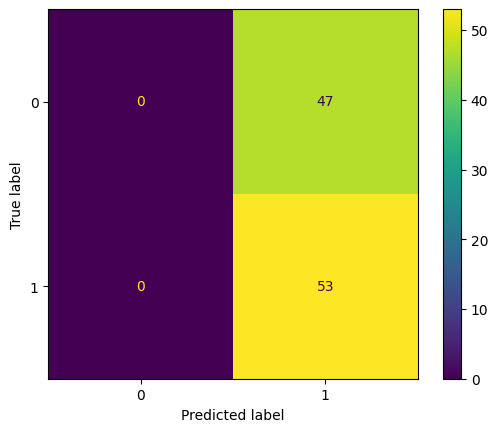

CPU times: user 3min 8s, sys: 628 ms, total: 3min 9s
Wall time: 3min 10s


In [ ]:
%%time

df_results = pd.DataFrame(columns = ['index', 'Question', 'True_Sentiment', 'Model_Sentiment'])

for i in test:
  the_prompt = sentiment_analysis_prompt(few_shots, i)

  inputs = tokenizer(the_prompt, return_tensors='pt')
  output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
  )

  new_row = pd.DataFrame([{
      "index": i,
      "Question": imdb_dataset['test'][i]['text'],
      "True_Sentiment": imdb_dataset['test'][i]['label'],
      "Model_Sentiment": output
      }])
  df_results = pd.concat([df_results,new_row], ignore_index=True)

# Print the table
print(df_results.head(10))
# Print matrix and accuracy
eval_conf_matrix(df_results,the_model)

## 2) T5 BASE (248M parameters; ~1.1GB)


In [ ]:
the_model = models_list[1]
print(the_model)

# Get the model
model = AutoModelForSeq2SeqLM.from_pretrained(the_model)
# Tokenize
tokenizer = AutoTokenizer.from_pretrained(the_model, use_fast=True)

google/flan-t5-base


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Token indices sequence length is longer than the specified maximum sequence length for this model (1395 > 512). Running this sequence through the model will result in indexing errors


   index                                           Question True_Sentiment  \
0  21544  First of all, I know almost nothing about rugb...              1   
1  17338  ****SPOILERS**** Buried under a mountain of me...              1   
2  21836  I first saw this movie when I was very little....              1   
3  11461  I must have been in a good mood to give this s...              0   
4   4672  spoilers<br /><br />This movie is not action p...              0   
5  12505  Overall, a well done movie. There were the par...              1   
6    355  SPOILER!! Terrible camera work, horrible writi...              0   
7  12279  Please -- if you haven't attempted to sit thro...              0   
8  15811  honestly.. this show warms my heart, i watch i...              1   
9   8980  Is there anything else on earth to be more ent...              0   

  Model_Sentiment  
0               1  
1               1  
2               1  
3               0  
4               0  
5               1  
6

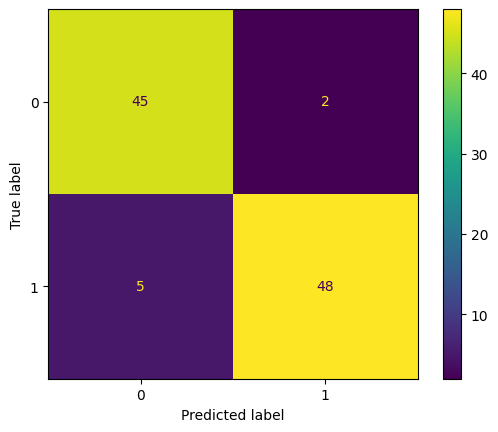

CPU times: user 12min 16s, sys: 1min 24s, total: 13min 41s
Wall time: 13min 44s


In [ ]:
%%time

df_results = pd.DataFrame(columns = ['index', 'Question', 'True_Sentiment', 'Model_Sentiment'])

for i in test:
  the_prompt = sentiment_analysis_prompt(few_shots, i)


  inputs = tokenizer(the_prompt, return_tensors='pt')
  output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
  )

  new_row = pd.DataFrame([{
      "index": i,
      "Question": imdb_dataset['test'][i]['text'],
      "True_Sentiment": imdb_dataset['test'][i]['label'],
      "Model_Sentiment": output
      }])
  df_results = pd.concat([df_results,new_row], ignore_index=True)

# Print the table
print(df_results.head(10))
# Print matrix and accuracy
eval_conf_matrix(df_results,the_model)

## 3) T5 LARGE (783M parameters; ~3.5GB)

In [ ]:
the_model = models_list[2]
print(the_model)

# Get the model
model = AutoModelForSeq2SeqLM.from_pretrained(the_model)
# Tokenize
tokenizer = AutoTokenizer.from_pretrained(the_model, use_fast=True)

google/flan-t5-large


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Token indices sequence length is longer than the specified maximum sequence length for this model (1395 > 512). Running this sequence through the model will result in indexing errors


   index                                           Question True_Sentiment  \
0  21544  First of all, I know almost nothing about rugb...              1   
1  17338  ****SPOILERS**** Buried under a mountain of me...              1   
2  21836  I first saw this movie when I was very little....              1   
3  11461  I must have been in a good mood to give this s...              0   
4   4672  spoilers<br /><br />This movie is not action p...              0   
5  12505  Overall, a well done movie. There were the par...              1   
6    355  SPOILER!! Terrible camera work, horrible writi...              0   
7  12279  Please -- if you haven't attempted to sit thro...              0   
8  15811  honestly.. this show warms my heart, i watch i...              1   
9   8980  Is there anything else on earth to be more ent...              0   

  Model_Sentiment  
0               1  
1               1  
2               1  
3               0  
4               0  
5               1  
6

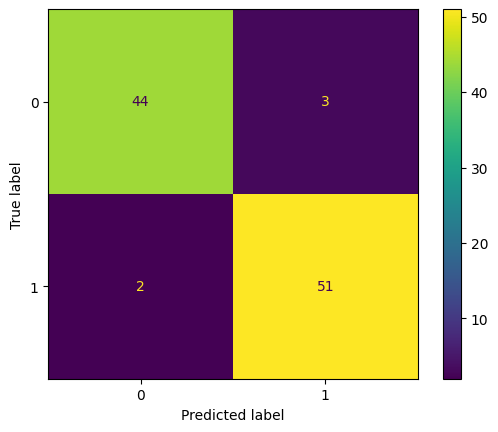

CPU times: user 41min 43s, sys: 5min 17s, total: 47min
Wall time: 47min 14s


In [ ]:
%%time

df_results = pd.DataFrame(columns = ['index', 'Question', 'True_Sentiment', 'Model_Sentiment'])

for i in test:
  the_prompt = sentiment_analysis_prompt(few_shots, i)


  inputs = tokenizer(the_prompt, return_tensors='pt')
  output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
  )

  new_row = pd.DataFrame([{
      "index": i,
      "Question": imdb_dataset['test'][i]['text'],
      "True_Sentiment": imdb_dataset['test'][i]['label'],
      "Model_Sentiment": output
      }])
  df_results = pd.concat([df_results,new_row], ignore_index=True)

# Print the table
print(df_results.head(10))
# Print matrix and accuracy
eval_conf_matrix(df_results,the_model)

## 4) T5 XL (2.85B parameters; ~10GB)

In [ ]:
the_model = models_list[3]
print(the_model)

# Get the model
model = AutoModelForSeq2SeqLM.from_pretrained(the_model)
# Tokenize
tokenizer = AutoTokenizer.from_pretrained(the_model, use_fast=True)

google/flan-t5-xl


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


   index                                           Question True_Sentiment  \
0  21544  First of all, I know almost nothing about rugb...              1   
1  17338  ****SPOILERS**** Buried under a mountain of me...              1   
2  21836  I first saw this movie when I was very little....              1   
3  11461  I must have been in a good mood to give this s...              0   
4   4672  spoilers<br /><br />This movie is not action p...              0   
5  12505  Overall, a well done movie. There were the par...              1   
6    355  SPOILER!! Terrible camera work, horrible writi...              0   
7  12279  Please -- if you haven't attempted to sit thro...              0   
8  15811  honestly.. this show warms my heart, i watch i...              1   
9   8980  Is there anything else on earth to be more ent...              0   

  Model_Sentiment  
0               1  
1               1  
2               1  
3               0  
4               0  
5               1  
6

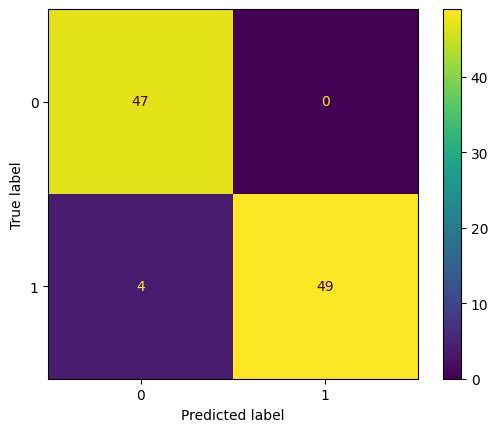

CPU times: user 6h 33min 15s, sys: 36min 40s, total: 7h 9min 56s
Wall time: 1h 47min 30s


In [ ]:
%%time

df_results = pd.DataFrame(columns = ['index', 'Question', 'True_Sentiment', 'Model_Sentiment'])

for i in test:
  the_prompt = sentiment_analysis_prompt(few_shots, i)


  inputs = tokenizer(the_prompt, return_tensors='pt')
  output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
  )

  new_row = pd.DataFrame([{
      "index": i,
      "Question": imdb_dataset['test'][i]['text'],
      "True_Sentiment": imdb_dataset['test'][i]['label'],
      "Model_Sentiment": output
      }])
  df_results = pd.concat([df_results,new_row], ignore_index=True)

# Print the table
print(df_results.head(10))
# Print matrix and accuracy
eval_conf_matrix(df_results,the_model)